#CafChem tools for using ODDT (Open Drug Discovery Toolkit) for similarity and interactions

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/ODDT_CafChem.ipynb)

## This notebook allows you to:
- load molecule SDFs and protein PDB/PDBQTs
- find specific interactions between residues and ligand atoms
- find similarity between molecules
- examine properties of molecules

## Requirements:

- Runs quickly on CPU

## Set-up

### Install libraries

In [1]:
!pip -q install oddt
!pip install -q rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 21.1 MB/s eta 0:00:00


### Import libraries

In [2]:
import oddt
from oddt.interactions import (close_contacts,
                               hbonds,
                               distance,
                               halogenbonds,
                               halogenbond_acceptor_halogen,
                               pi_stacking,
                               salt_bridges,
                               pi_cation,
                               hydrophobic_contacts)

from oddt.shape import usr, usr_cat, electroshape, usr_similarity

import pandas as pd
import numpy as np

##Work with molecules

In [3]:
mol = oddt.toolkit.readstring('smi', '[NH3+]CCc1ccc(O)cc1')
mol2 = oddt.toolkit.readstring('smi', 'O=C([O-])CCc1ccc(OC)cc1')


In [4]:
for bond in mol2.bonds:
  print(bond.order)

2.0
1.0
1.0
1.0
1.0
1.5
1.5
1.5
1.0
1.0
1.5
1.5
1.5


In [5]:
mol.make3D()

[08:44:07] Molecule does not have explicit Hs. Consider calling AddHs()
[08:44:07] Molecule does not have explicit Hs. Consider calling AddHs()


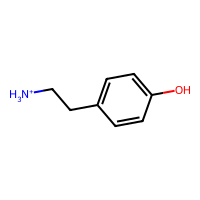

In [6]:
mol

In [7]:
acceptors = mol.atom_dict['isacceptor']
donors = mol.atom_dict['isdonor']
hydrophobics = mol.atom_dict['ishydrophobe']
negatives = mol.atom_dict['isminus']
positives = mol.atom_dict['isplus']
halogens = mol.atom_dict['ishalogen']
types = mol.atom_dict['atomtype']
idxs = mol.atom_dict['id']
aromatics = mol.atom_dict['isaromatic']
identities = [f'{id}_{atype}' for id, atype in zip(idxs, types)]

atom_dict = {'identity': identities,
             'acceptors': acceptors,
             'donors': donors,
             'hydrophobics': hydrophobics,
             'negatives': negatives,
             'positives': positives,
             'halogens': halogens,
             'aromatic': aromatics}
atom_df = pd.DataFrame(atom_dict)
atom_df.head()

,identity,acceptors,donors,hydrophobics,negatives,positives,halogens,aromatic
0,0_N.4,False,True,False,False,True,False,False
1,1_C.3,False,False,False,False,False,False,False
2,2_C.3,False,False,True,False,False,False,False
3,3_C.ar,False,False,True,False,False,False,True
4,4_C.ar,False,False,True,False,False,False,True


#### Similarity

In [8]:
mol1_file = '/content/5Kanneal3S_S10_test6_-9.2_12.sdf'
mol2_file = '/content/5Kanneal3S_S10_test6_-8.6_3.sdf'

In [9]:
mol1 = next(oddt.toolkit.readfile('sdf',mol1_file))
mol2 = next(oddt.toolkit.readfile('sdf',mol2_file))

In [10]:
## USR

query_shape = usr(mol1)
reference_shape = usr(mol2)

similarity = usr_similarity(query_shape, reference_shape)
print(f'Similarity: {similarity}')

Similarity: 0.5303870650251774


In [11]:
## USR_cat

query_shape = usr_cat(mol1)
reference_shape = usr_cat(mol2)

similarity = usr_similarity(query_shape, reference_shape)
print(f'Similarity: {similarity}')

Similarity: 0.21625213241932673


In [12]:
## uses electrostatics

query_shape = electroshape(mol1)
reference_shape = electroshape(mol2)

similarity = usr_similarity(query_shape, reference_shape)
print(f'Similarity: {similarity}')

Similarity: 0.7386242304599792


## Protein-ligand systems

### Define protein and ligand

In [13]:
protein_file = '/content/HMGCR_dude_receptor.pdb'
ligand_file = '/content/5Kanneal3S_S10_test6_-9.2_12.sdf'

In [14]:
pro = next(oddt.toolkit.readfile('pdb',protein_file))
lig = next(oddt.toolkit.readfile('sdf',ligand_file))
pro.protein = True

In [16]:
residues_list = ['tyr']
for res in pro.residues:
  if res.name.lower() in residues_list:
    print(res.name, res.number)

TYR 71
TYR 93
TYR 309
TYR 321
TYR 352
TYR 460
TYR 492
TYR 495
TYR 498
TYR 500
TYR 514
TYR 625
TYR 655
TYR 668
TYR 730
TYR 742
TYR 1083
TYR 1145
TYR 1188
TYR 1435


### Analysis function

In [17]:
def int_analysis(pro_atoms, lig_atoms, int_type: str, strict_parallel = None, strict_perpendicular = None):

  int_types = ['hbond', 'hydrophobic_contact', 'pi_cation', 'halogenbonds', 'salt_bridges']
  if int_type in int_types:
    assert len(pro_atoms) == len(lig_atoms)
    atoms = []
    residues = []
    for atom, res in zip(lig_atoms, pro_atoms):
      atom_name = str(atom['atomtype']).split('.')[0]
      atom_number = str(atom['id'])
      res_name = str(res['resname'])
      res_number = str(res['resnum'])
      res_id = res_name+res_number
      print(f'Atom {atom_name}-{atom_number} forms a {int_type} with {res_id}')
      atoms.append(atom_number)
      residues.append(res_id)

    atoms = list(set(atoms))
    residues = list(set(residues))
    print(f'The total number of atoms involved in {int_type}s are {len(atoms)}')
    print(f'The total number of residues involved in {int_type}s are {len(residues)}')

  if int_type == 'pi_stacking':
    residues = []
    for res in pro_atoms:
      res_name = str(res['resname'])
      res_number = str(res['resnum'])
      res_id = res_name+res_number
      print(f'{res_id} forms pi-stacking interactions with the Ligand')
      residues.append(res_id)
      para = strict_parallel.sum()
      perp = strict_perpendicular.sum()

    residues = list(set(residues))
    print(f'The total number of residues involved in {int_type}s are {len(residues)}')
    try:
      print(f'The total number of parallel interactions are {para}')
      print(f'The total number of perpendicular interactions are {perp}')
    except:
      pass



### Find interactions

#### Hydrogen-bonds

In [18]:
pro_atoms, lig_atoms, strict = hbonds(pro, lig)

In [19]:
assert len(pro_atoms) == len(lig_atoms)

In [20]:
int_analysis(pro_atoms, lig_atoms, 'hbond')

Atom O-31 forms a hbond with ASP671
Atom F-12 forms a hbond with GLU646
Atom N-17 forms a hbond with SER125
Atom N-17 forms a hbond with ARG128
Atom N-17 forms a hbond with SER412
Atom O-29 forms a hbond with ASN315
Atom O-29 forms a hbond with ASP671
Atom O-29 forms a hbond with LYS672
Atom O-31 forms a hbond with ARG571
Atom O-31 forms a hbond with ASP671
The total number of atoms involved in hbonds are 4
The total number of residues involved in hbonds are 8


#### Pi-stacking

In [21]:
pro_atoms, lig_atoms,strict_parallel, strict_perpendicular = pi_stacking(pro, lig)
int_analysis(pro_atoms, lig_atoms, 'pi_stacking', strict_parallel, strict_perpendicular )

The total number of residues involved in pi_stackings are 0


#### Hydrophobic contact

In [22]:
pro_atoms, lig_atoms = hydrophobic_contacts(pro, lig)

In [23]:
int_analysis(pro_atoms, lig_atoms, 'hydrophobic_contact')

Atom C-21 forms a hydrophobic_contact with GLU119
Atom C-30 forms a hydrophobic_contact with HIS312
Atom C-0 forms a hydrophobic_contact with LEU413
Atom C-1 forms a hydrophobic_contact with LEU413
Atom C-2 forms a hydrophobic_contact with LEU413
Atom C-4 forms a hydrophobic_contact with LEU413
Atom C-5 forms a hydrophobic_contact with LEU413
Atom C-23 forms a hydrophobic_contact with LEU413
Atom C-20 forms a hydrophobic_contact with LEU413
Atom C-30 forms a hydrophobic_contact with LEU413
Atom C-10 forms a hydrophobic_contact with LEU417
Atom C-11 forms a hydrophobic_contact with LEU417
Atom C-10 forms a hydrophobic_contact with VAL664
The total number of atoms involved in hydrophobic_contacts are 11
The total number of residues involved in hydrophobic_contacts are 5


#### Pi-cation

In [24]:
pro_atoms, lig_atoms, strict = pi_cation(pro, lig, tolerance=30)

In [25]:
int_analysis(pro_atoms, lig_atoms, 'pi_cation')

The total number of atoms involved in pi_cations are 0
The total number of residues involved in pi_cations are 0


#### Halogen bonds

In [26]:
pro_atoms, lig_atoms, strict = halogenbonds(pro, lig, tolerance=30)

In [27]:
int_analysis(pro_atoms, lig_atoms, 'halogenbonds')

Atom F-12 forms a halogenbonds with GLU646
The total number of atoms involved in halogenbondss are 1
The total number of residues involved in halogenbondss are 1


#### salt bridge

In [28]:
pro_atoms, lig_atoms = salt_bridges(pro, lig)

In [29]:
int_analysis(pro_atoms, lig_atoms, 'salt_bridges')

The total number of atoms involved in salt_bridgess are 0
The total number of residues involved in salt_bridgess are 0
